In [4]:
import author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sys
sys.path.insert(0, "/Users/jin/Programming/Machine_Learning/All-about-Market/trading/Jeong/machine_trade/code")
import eval_model
from functools import reduce
engine = author.processed_engine
raw_engine = author.raw_engine

각 종목 별로 유의미한 피쳐들을 선정해 사용한다. </br>
* BTC: Macd_signal, Vwap, Pct, Macd_Gap, Moment, Fast_d, Rsi
* TLT: Macd_signal, Vwap, Pct, Macd_Gap, Moment, Fast_d
* QQQ: Macd_signal, Vwap, pct, Moment, Rsi, Macd_Gap
* GCF: Macd_signal, Vwap, pct, Moment

* Vix나 USDT 같은 지표 들은 그냥 값을 그대로 활용했다. 부가적인 요소들을 사용하지 않았다.

비트코인의 데이터 만으로 가격을 예측 할 수 있을까? </br>
비트코인은 다른 자산과의 상관관계도 높은 편이고 과적합을 피하기 위해서라도 다른 자산의 피쳐를 활용하는 것은 </br>
현명한 생각으로 보여진다.

금, 미국 장기채, 나스닥, 금선물의 추세지표를 가져온다.

VIX(변동성 지표)와 달러 인덱스도 가져온다.

In [5]:
def get_df(query, engine):
    df = pd.read_sql(query, engine) #로컬 db에서 테이블 가져옴
    df.set_index(df.columns[0], inplace=True)
    return df

select_all = lambda ticker: f"SELECT * FROM {ticker}_1d"
bit_df = get_df(select_all("BTCUSD"), engine)
qqq_df = get_df(select_all("QQQ"), engine)
tlt_df = get_df(select_all("TLT"), engine)
gld_df = get_df(select_all("GCF"), engine)

bit_fedf = bit_df[["Macd_Signal", "Vwap", "Pct", "Moment", "Fast_d", "Rsi","Price"]]


vix = get_df("SELECT Date, Close FROM VIX_1d", raw_engine)
usd = get_df("SELECT Date, Close FROM DXF_1d", raw_engine)
tnx = get_df("SELECT Date, Close FROM TNX_1d", raw_engine) #국채금리

data_frames = [bit_fedf, vix, usd,tnx]
for df, ticker in zip(data_frames, ["BTC","VIX","USD","TNX"]):
    df.columns = [f"{ticker}_{c}" for c in df.columns]

df = reduce(lambda left,right: pd.merge(left, right, right_index=True, left_index=True,
                                            how='outer'), data_frames)

df = df.ffill().dropna()
df = df.drop_duplicates()
test_df, df_merged = df[-100:], df[:-100]
df


,BTC_Macd_Signal,BTC_Vwap,BTC_Pct,BTC_Moment,BTC_Fast_d,BTC_Rsi,BTC_Price,VIX_Close,USD_Close,TNX_Close
2015-02-28,2.738,240.599,0.171,0.916,17.051,58.802,254.263,13.340000,95.320999,2.002
2015-03-01,3.969,240.808,2.336,0.930,25.940,61.534,260.202,13.340000,95.320999,2.002
2015-03-02,6.123,241.435,5.945,0.965,30.447,67.566,275.670,13.040000,95.478996,2.084
2015-03-03,8.221,242.400,2.188,0.980,28.741,69.571,281.702,13.860000,95.407997,2.122
2015-03-04,9.085,243.084,-3.056,0.964,22.262,63.536,273.092,14.230000,95.986000,2.123
...,...,...,...,...,...,...,...,...,...,...
2022-05-04,-943.277,27887.285,5.160,61.846,17.622,48.366,39698.371,25.420000,102.594002,2.917
2022-05-05,-1073.475,27897.073,-7.867,61.371,16.616,38.143,36575.141,31.200001,103.802002,3.066
2022-05-06,-1205.865,27904.415,-1.461,60.949,14.637,36.714,36040.922,30.190001,103.680000,3.123
2022-05-07,-1338.842,27908.839,-1.495,60.490,12.998,35.278,35501.953,30.190001,103.680000,3.123


모델을 학습 시켜보자. 자산을 추가함으로써 내가 얻고 싶은 것들은 아래와 같다.
* 모델의 과적합 해소
* 모델이 폭락, 폭등에 조금이나마 적응
* 특정 기간에만 잘 맞는 현상 제거

In [6]:
ridge_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=False)),
    ('min_max', MinMaxScaler()),
    ('regulator', Ridge(alpha=1,solver="cholesky",random_state=42,fit_intercept=True))
])

lasso_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=True)),
    ('min_max', MinMaxScaler()),
    ('regulator', Lasso(alpha=1,random_state=42,fit_intercept=True))
])

elastic_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=True)),
    ('min_max', MinMaxScaler()),
    ('regulator', ElasticNet(alpha=1,random_state=42,fit_intercept=True,l1_ratio=0.7))
])

rf_model = Pipeline([
    ('min_max',MinMaxScaler()),
    ('machine',RandomForestRegressor(bootstrap=True, random_state=42, oob_score=True, max_depth=2000))
])

In [7]:
def create_train_data(df):
    """ 트레이닝 데이터를 생성한다. 
        다음날 데이터를 예측 해야 하므로 한 칸씩 미뤄주고 댕겨준다.
    """
    X = df.drop(['BTC_Price'], axis=1).iloc[:-1]
    y = df['BTC_Price'].iloc[1:]
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=24)
    return train_X, test_X, train_y, test_y

In [8]:
train_X, test_X, train_y, test_y = create_train_data(df)
ridge_model.fit(train_X, train_y)
lasso_model.fit(train_X, train_y)
elastic_model.fit(train_X, train_y)
rf_model.fit(train_X, train_y)

Pipeline(steps=[('min_max', MinMaxScaler()),
                ('machine',
                 RandomForestRegressor(max_depth=2000, oob_score=True,
                                       random_state=42))])

In [9]:
def plot_coef(coef, index, intercept=False):
    if intercept:
        index = index.insert(0, "Intercept")
    coef_df = pd.DataFrame(data=coef,index=index,columns=["Coef"])
    coef_df.plot.bar(figsize=(12,8))

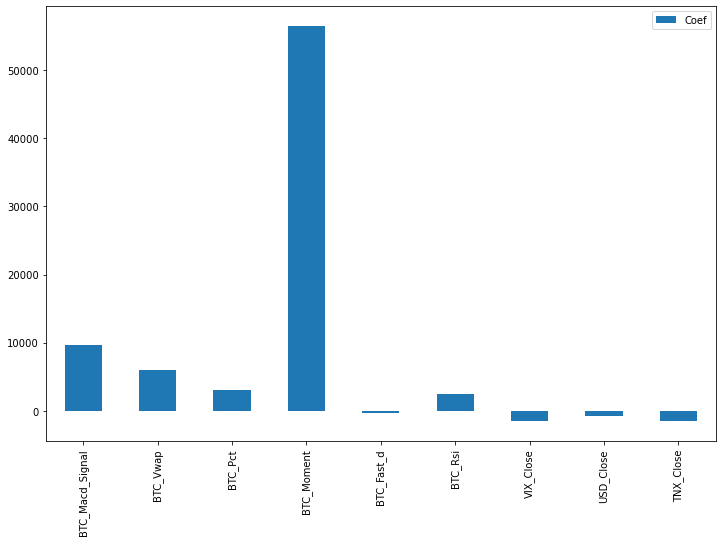

In [10]:
plot_coef(ridge_model['regulator'].coef_, train_X.columns)

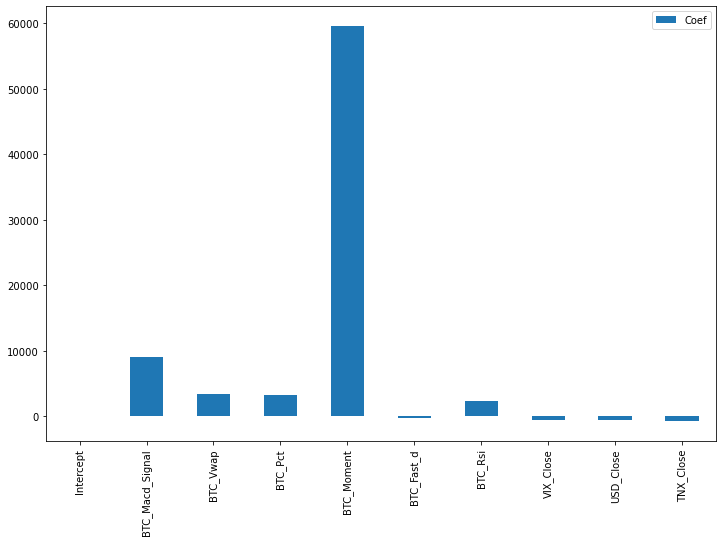

In [11]:
plot_coef(lasso_model['regulator'].coef_, train_X.columns,True)

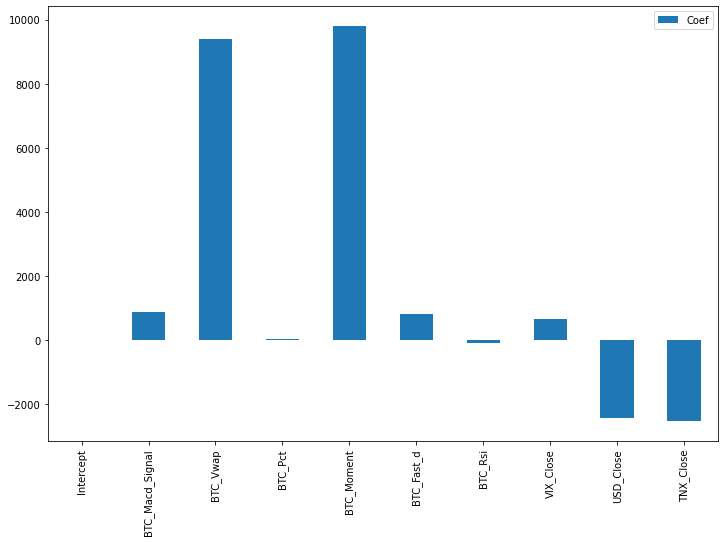

In [12]:
plot_coef(elastic_model['regulator'].coef_, train_X.columns, True)


In [13]:
def find_best_alpha(train_X, train_y, test_X, test_y, model):
    """파라미터 값을 변경해가며 알파 값을 바꿔본다."""
    best_alpha = 1
    best_mse = float('inf')
    for i in [1000,300,100,30,10,1,0.1,0.03,0.01,0.001]:
        model.set_params(regulator__alpha=i)
        model.fit(train_X, train_y)
        pred = model.predict(test_X)
        mse = ((test_y - pred) ** 2).mean()
        if best_mse > mse:
            best_mse = mse
            best_alpha = i
        print(f'mse: {mse}, alpha: {i}')
    return best_alpha

ridge_model.set_params(poly_features__degree=3)
r_alpha = find_best_alpha(train_X, train_y, test_X, test_y, ridge_model)
ridge_model.set_params(regulator__alpha=r_alpha)
ridge_model.fit(train_X, train_y)

lasso_model.set_params(poly_features__degree=3)
l_alpha = find_best_alpha(train_X, train_y, test_X, test_y, lasso_model)
lasso_model.set_params(regulator__alpha=l_alpha)
lasso_model.fit(train_X, train_y)

elastic_model.set_params(poly_features__degree=3)
e_alpha = find_best_alpha(train_X, train_y, test_X, test_y, elastic_model)
elastic_model.set_params(regulator__alpha=e_alpha)
elastic_model.fit(train_X, train_y)



mse: 23606095.441558138, alpha: 1000
mse: 8872267.380634787, alpha: 300
mse: 5051227.231740791, alpha: 100
mse: 3142072.527381364, alpha: 30
mse: 2086521.195815029, alpha: 10
mse: 1278640.6240956509, alpha: 1
mse: 1173573.2798083469, alpha: 0.1
mse: 1358815.4318910455, alpha: 0.03
mse: 1708853.679072195, alpha: 0.01
mse: 2419021.2680334332, alpha: 0.001
mse: 21143358.108374048, alpha: 1000
mse: 5422740.185003418, alpha: 300
mse: 2253874.189971134, alpha: 100
mse: 1714514.68370876, alpha: 30
mse: 1506701.2647456827, alpha: 10
mse: 1252635.8636251497, alpha: 1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228083230.6887945, tolerance: 51561360.622759596
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 576403101.294701, tolerance: 51561360.622759596
  model = cd_fast.enet_coordinate_descent(


mse: 1251331.408622965, alpha: 0.1
mse: 2003669.6532320727, alpha: 0.03


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 607784507.9626393, tolerance: 51561360.622759596
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 609281378.2924562, tolerance: 51561360.622759596
  model = cd_fast.enet_coordinate_descent(


mse: 2551086.9238281553, alpha: 0.01
mse: 3010918.1757862996, alpha: 0.001


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605456174.4960879, tolerance: 51561360.622759596
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 576403101.294701, tolerance: 51561360.622759596
  model = cd_fast.enet_coordinate_descent(


mse: 290076729.0305492, alpha: 1000
mse: 281533483.6564838, alpha: 300
mse: 259097403.8905647, alpha: 100
mse: 199477436.77310166, alpha: 30
mse: 112816114.43167005, alpha: 10
mse: 13858647.303566992, alpha: 1
mse: 3975414.5580933494, alpha: 0.1
mse: 2500050.034128686, alpha: 0.03


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3700788633.299302, tolerance: 51561360.622759596
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2173054582.508092, tolerance: 51561360.622759596
  model = cd_fast.enet_coordinate_descent(


mse: 1710791.5180907804, alpha: 0.01
mse: 1221893.9878076138, alpha: 0.001


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 963954554.1479548, tolerance: 51561360.622759596
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 963954554.1479548, tolerance: 51561360.622759596
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('min_max', MinMaxScaler()),
                ('regulator',
                 ElasticNet(alpha=0.001, l1_ratio=0.7, random_state=42))])

In [14]:
def visualize(pred,target,name):
    plt.figure(figsize=(20,12))
    index = np.arange(len(target))
    plt.scatter(index, target,label='target')
    plt.scatter(index, pred,label='model')
    mse = np.mean((target - pred) ** 2)
    plt.suptitle(f'{name}',fontsize=20)
    plt.title(f'MSE is {mse:.3f}')
    plt.legend()

In [15]:
r_pred = ridge_model.predict(test_X)
l_pred = lasso_model.predict(test_X)
e_pred = elastic_model.predict(test_X)
rf_pred = rf_model.predict(test_X)


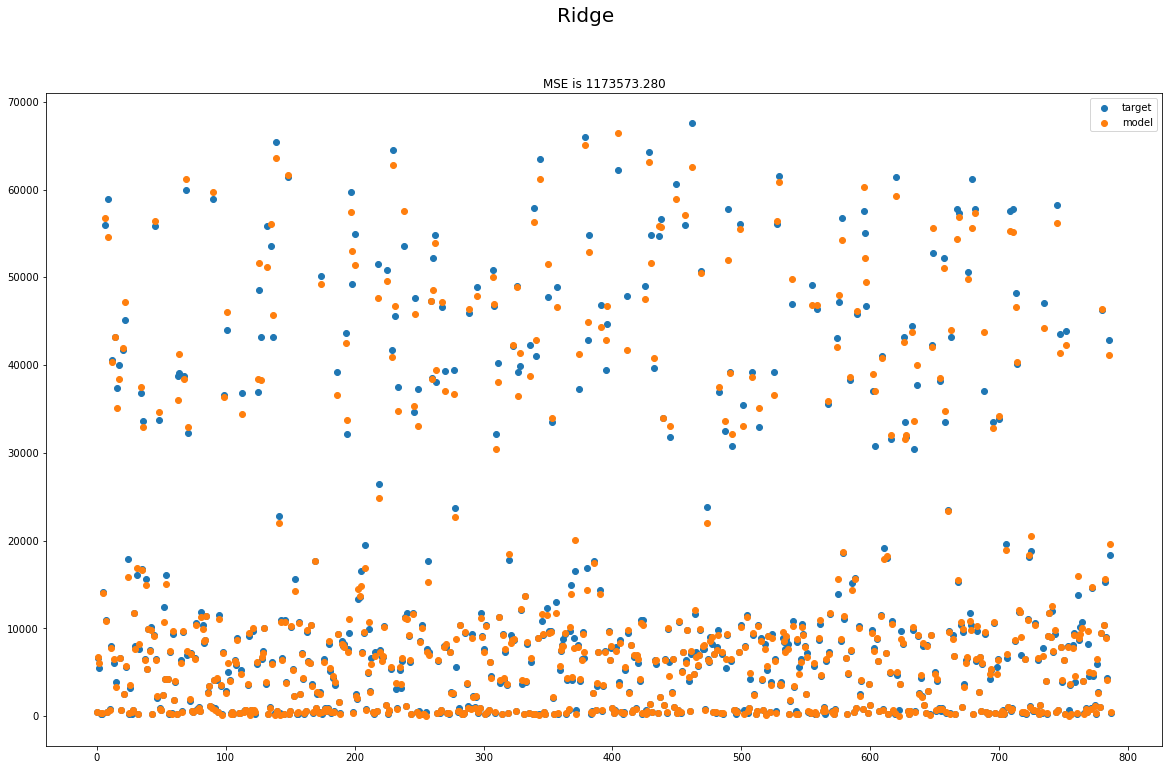

In [16]:
visualize(r_pred, test_y, "Ridge")

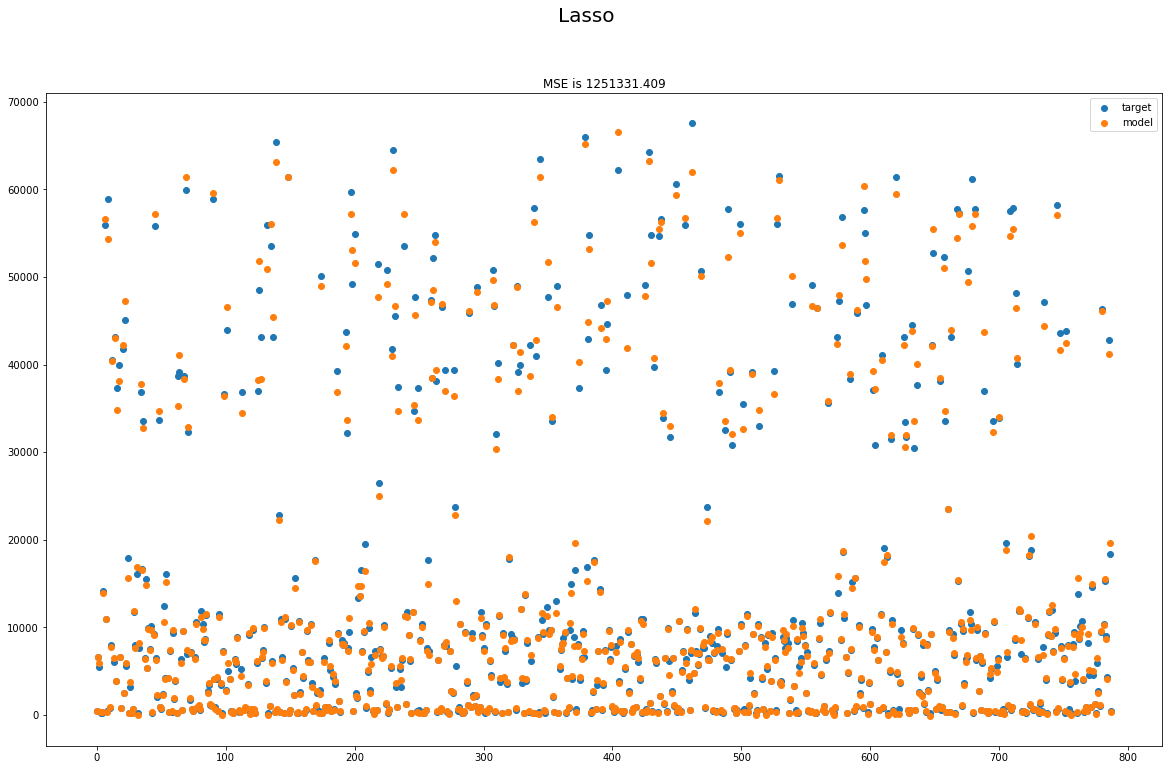

In [17]:
visualize(l_pred, test_y, "Lasso")


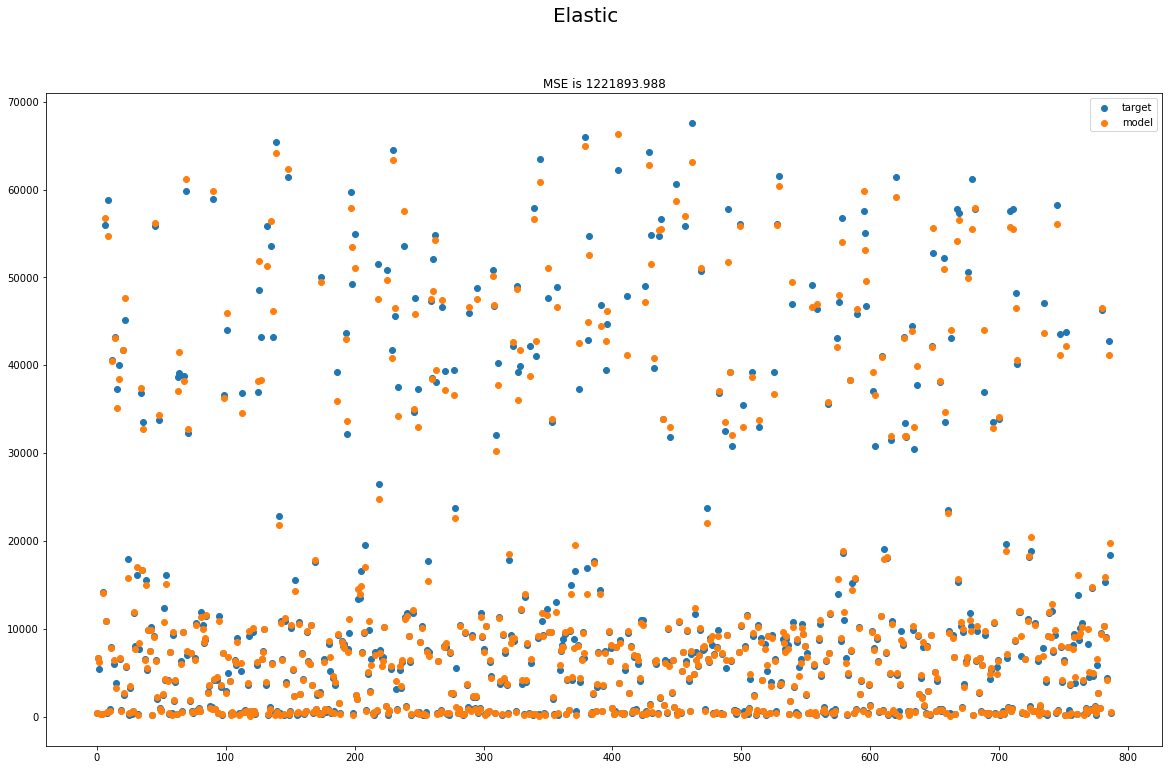

In [18]:
visualize(e_pred, test_y, "Elastic")

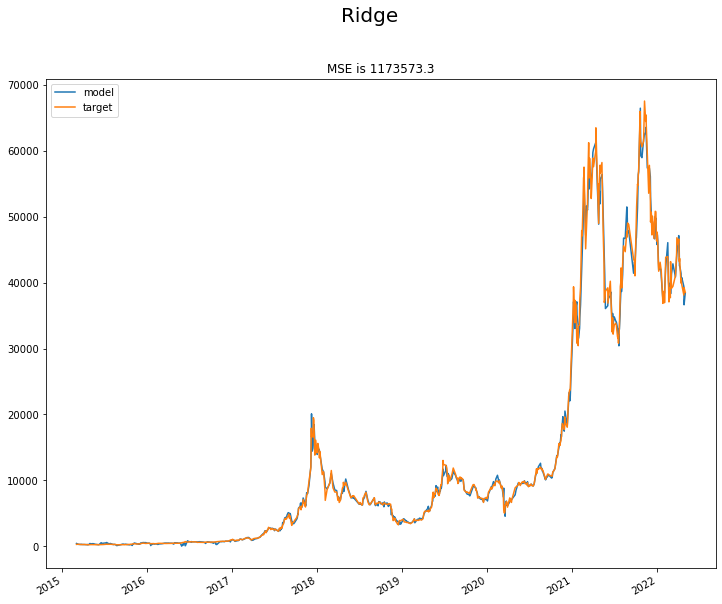

In [19]:
eval_model.visualize_plot(r_pred, test_y, "Ridge")


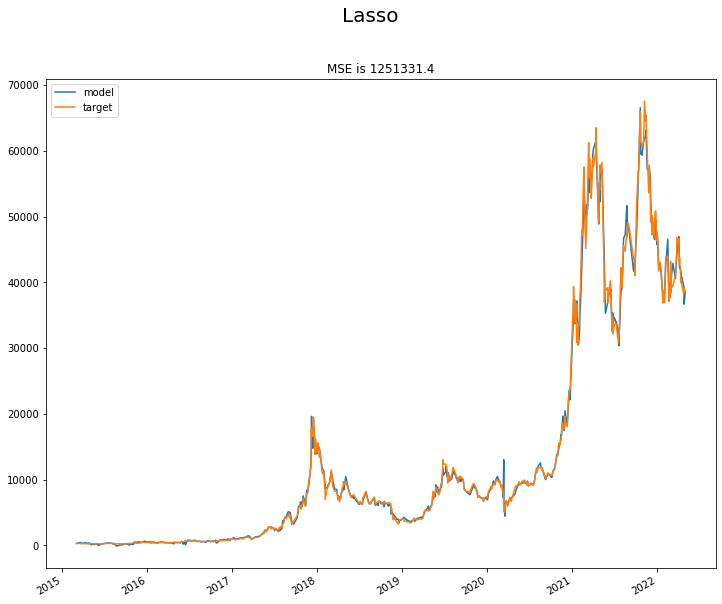

In [20]:
eval_model.visualize_plot(l_pred, test_y, "Lasso")


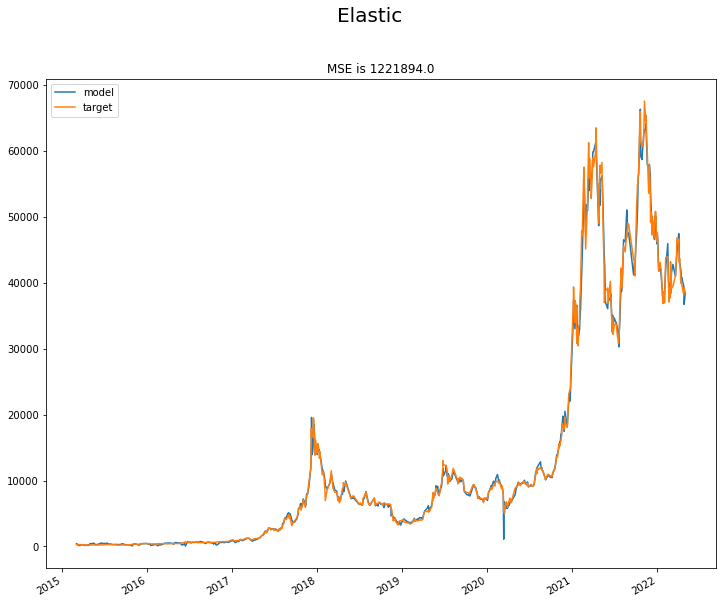

In [21]:
eval_model.visualize_plot(e_pred, test_y, "Elastic")


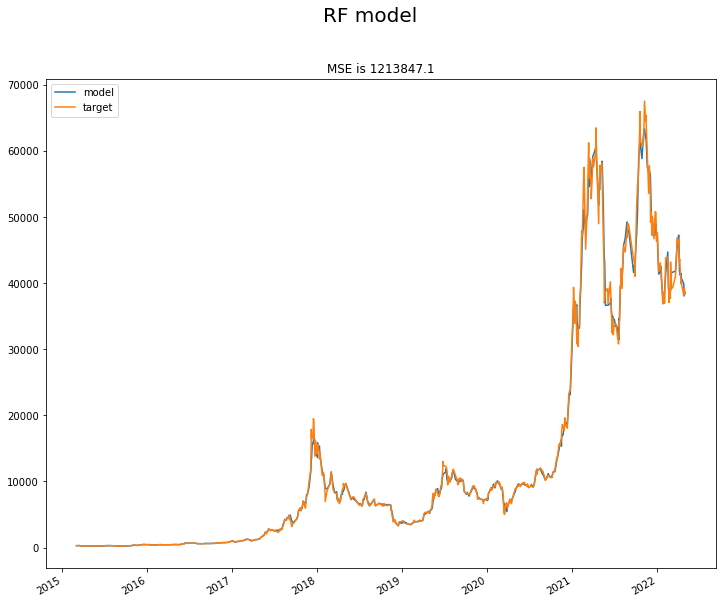

In [35]:
eval_model.visualize_plot(rf_pred, test_y, "RF model")


In [22]:
# import model
# model = model.MyModel()
# model.create_random_forest(df, target='BTC_Price', outlier=False,start=2,end=100,gap=5)

근래 존재하던 100거래일 동안의 모델의 퍼포먼스를 살펴보자
* 100일 간의 데이터는 학습하지 않은 데이터이다.

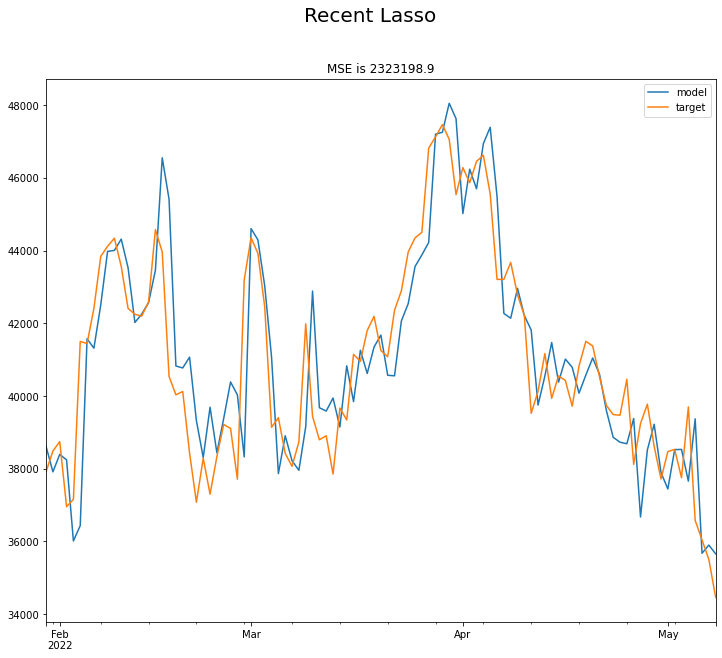

In [24]:
recent_X = test_df.drop('BTC_Price',axis=1).iloc[:-1]
recent_y = test_df['BTC_Price'].iloc[1:]
l_test_pred = lasso_model.predict(recent_X)
eval_model.visualize_plot(l_test_pred, recent_y, name="Recent Lasso")

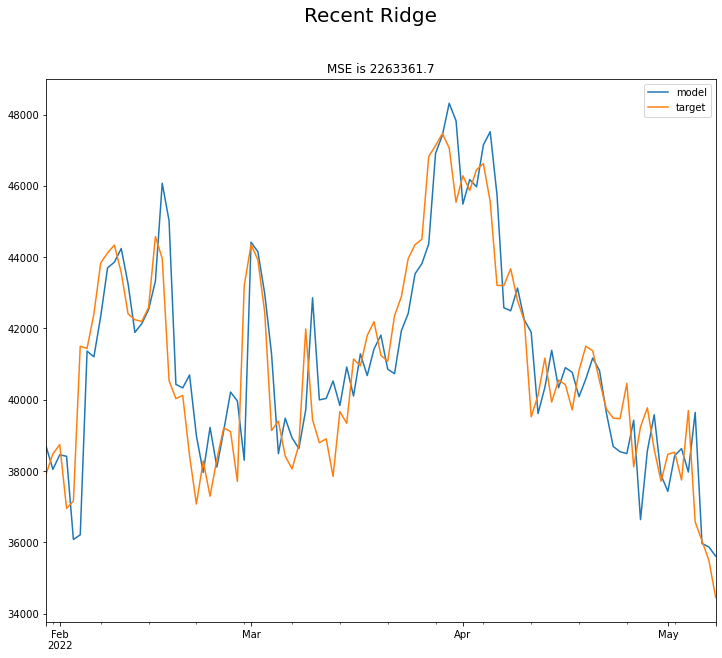

In [25]:
r_test_pred = ridge_model.predict(recent_X)
eval_model.visualize_plot(r_test_pred, recent_y, name="Recent Ridge")


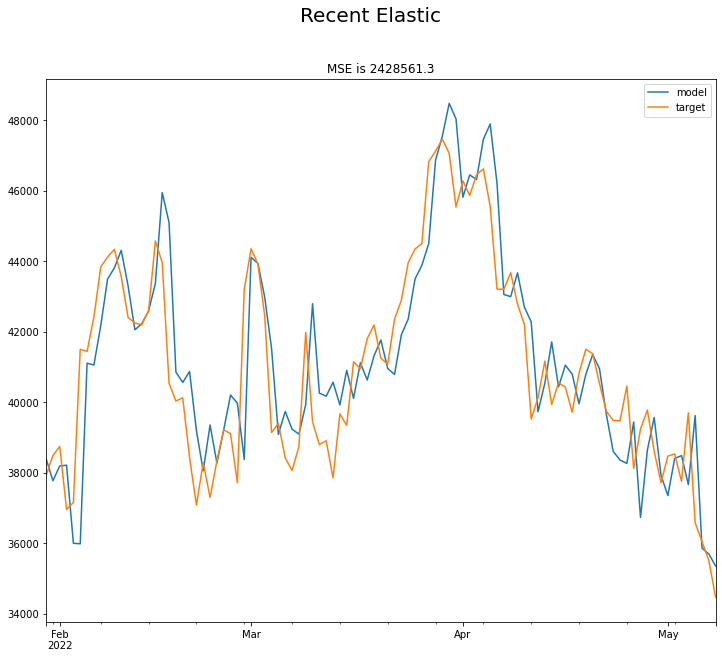

In [26]:
e_test_pred = elastic_model.predict(recent_X)
eval_model.visualize_plot(e_test_pred, recent_y, name="Recent Elastic")


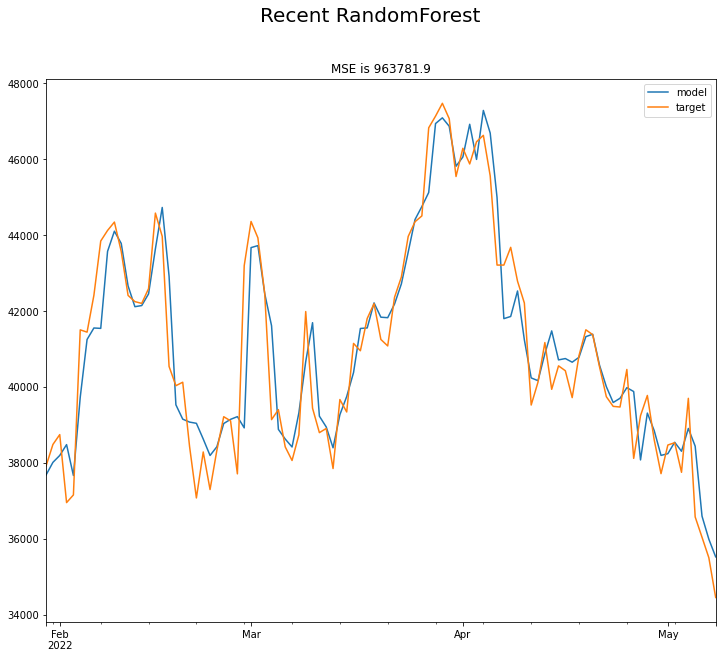

In [34]:
rf_test_pred = rf_model.predict(recent_X)
eval_model.visualize_plot(rf_test_pred, recent_y, name="Recent RandomForest")


In [28]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
tscv = TimeSeriesSplit(n_splits=20)
train_X = df_merged.drop(['BTC_Price'], axis=1).iloc[1:]
train_y = df_merged['BTC_Price'].iloc[:-1]
cv_result = []
for m in [ridge_model, lasso_model, elastic_model]:
    result = []
    for i, (train_index, test_index) in enumerate(tscv.split(train_X)):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        model = m.fit(X_train, y_train)
        pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, pred)
        mse = np.sqrt(mean_squared_error(y_test, pred))
        score = r2_score(y_test, pred)
        adj_score = 1 - (1 - r2_score(y_test, pred)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
        result.append([mae, mse, score, adj_score])
    cv_result.append(pd.DataFrame(data = result, columns=["mae","mse","score","ajd_score"]))

/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.122163090669346, tolerance: 12.830460975608537
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 438.0854913156418, tolerance: 203.7105948626722
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38797.20381447091, tolerance: 21707.838101223628
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib

In [29]:
cv_result[0] #ridge

,mae,mse,score,ajd_score
0,8.158170,9.682826,0.855438,0.843610
1,28.670238,32.089499,0.360117,0.307763
2,11.281530,14.432215,0.976628,0.974716
3,24.036155,29.426543,0.234510,0.171879
4,18.510679,27.151143,0.952670,0.948797
5,286.199464,464.957454,0.402718,0.353849
6,187.254765,242.658299,0.940340,0.935458
7,3256.026539,4601.341447,-0.464984,-0.584846
8,1624.135655,1814.851391,-1.010788,-1.175307
9,413.178964,489.660108,0.130570,0.059435


In [30]:
cv_result[1] #lasso

,mae,mse,score,ajd_score
0,6.867750,8.522189,0.888017,0.878855
1,53.041508,59.264754,-1.182569,-1.361143
2,35.932003,49.377361,0.726419,0.704035
3,33.365023,39.591455,-0.385683,-0.499057
4,35.532008,45.219703,0.868714,0.857973
5,175.014606,266.778252,0.803368,0.787280
6,162.452972,204.122083,0.957784,0.954330
7,1779.409646,2297.348571,0.634811,0.604932
8,1567.362720,1662.257058,-0.686866,-0.824882
9,390.188286,437.484938,0.305981,0.249197


In [31]:
cv_result[2] #elastic

,mae,mse,score,ajd_score
0,8.802204,11.100504,0.810008,0.794463
1,24.126132,28.017080,0.512224,0.472315
2,11.130184,14.630435,0.975982,0.974016
3,23.022634,26.535945,0.377513,0.326583
4,20.093703,28.992963,0.946031,0.941615
5,104.483014,157.197688,0.931728,0.926142
6,389.385619,485.525909,0.761153,0.741611
7,3415.090441,5543.159971,-1.126075,-1.300027
8,1618.836449,1790.730497,-0.957693,-1.117868
9,536.393936,632.505596,-0.450688,-0.569381


In [32]:
for name, cv in zip(["Ridge","Lasso","Elastic"], cv_result):
    print(f"{name}:\n {cv.mean()}")

Ridge:
 mae          1130.321481
mse          1441.251071
score           0.478231
ajd_score       0.435540
dtype: float64
Lasso:
 mae          1134.035169
mse          1443.136379
score           0.416507
ajd_score       0.368766
dtype: float64
Elastic:
 mae          1229.227695
mse          1520.161163
score           0.424692
ajd_score       0.377621
dtype: float64


엘라스틱 모델의 퍼포먼스가 가장 괜찮게 나왔다. </br>
새로운 자산을 추가하는 것이 그다지 큰 효과를 발휘하고 있지 않다는 생각이 든다.</br>
* 이는 아마 주식 데이터는 평일에만 열리게 되므로 주말 간의 데이터가 손실 된 것이 어느정도 기여를 하지 않나 싶다.

In [33]:
import joblib
joblib.dump(lasso_model, "Lasso_total.pkl")
joblib.dump(ridge_model, "Ridge_total.pkl")
joblib.dump(elastic_model, "Elastic_total.pkl")


['Elastic_total.pkl']